In [1]:
import os, warnings
warnings.filterwarnings("ignore")

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")   # suppress warnings


In [5]:
data_dir = "./"   # current directory where your notebook and CSVs are
file_path = data_dir + "salesmonthly.csv"
df = pd.read_csv(file_path)

In [ ]:
def run_sarima(filename, freq, seasonal_period, forecast_steps=12, column="M01AB"):
    print(f"\n=== Running SARIMA for {filename} ===")
    
    # Load dataset
    df = pd.read_csv(filename)
    df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
    df = df.dropna(subset=['datum']).sort_values('datum').set_index('datum')
    
    series = series.asfreq(freq).fillna(method="ffill").fillna(method="bfill")
    
    # Train-test split
    h = forecast_steps
    train, test = series[:-h], series[-h:]
    
    # Model orders
    order = (1,1,1)
    seasonal = (1,1,1,seasonal_period)
    
    # Fit SARIMA with stable optimizer
    try:
        model = SARIMAX(train, order=order, seasonal_order=seasonal,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, method="powell", maxiter=500)  # <-- stable
    except:
        print("Retrying with simpler seasonal order...")
        seasonal = (0,1,1,seasonal_period)
        model = SARIMAX(train, order=order, seasonal_order=seasonal,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, method="powell", maxiter=500)
    
    # Forecast
    pred = res.get_forecast(steps=len(test))
    pred_mean = pred.predicted_mean
    
    rmse = mean_squared_error(test, pred_mean, squared=False)
    print("AIC:", res.aic, "| Test RMSE:", rmse)
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(pred_mean.index, pred_mean, label="Forecast")
    plt.title(f"SARIMA Forecast - {filename}")
    plt.legend()
    plt.show()
    
    # Refit full model for future forecast
    res_full = SARIMAX(series, order=order, seasonal_order=seasonal,
                       enforce_stationarity=False, enforce_invertibility=False).fit(
                           disp=False, method="powell", maxiter=500)
    
    future = res_full.get_forecast(steps=h).predicted_mean
    print("Next period forecast:\n", future.head())
    return res_full, future


=== Running SARIMA for salesmonthly.csv ===
AIC: 324.4680399815037 | Test RMSE: 61.674086043731066


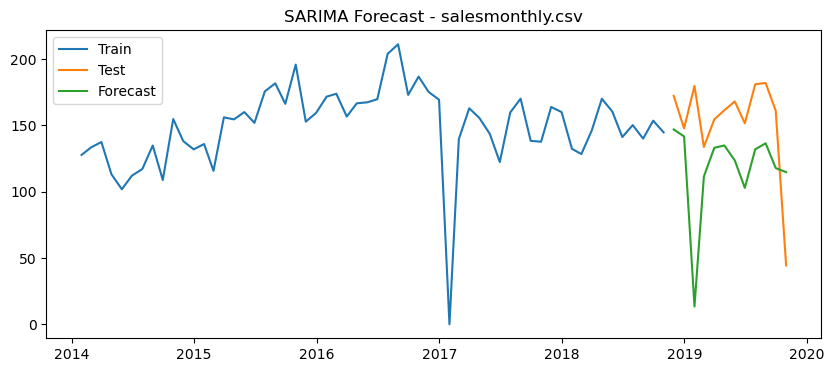

Next period forecast:
 2019-11-30    139.546002
2019-12-31    144.177658
2020-01-31    111.740261
2020-02-29    129.601892
2020-03-31    145.834438
Freq: ME, Name: predicted_mean, dtype: float64

=== Running SARIMA for salesweekly.csv ===
AIC: 1350.5126321451849 | Test RMSE: 11.130264712552826


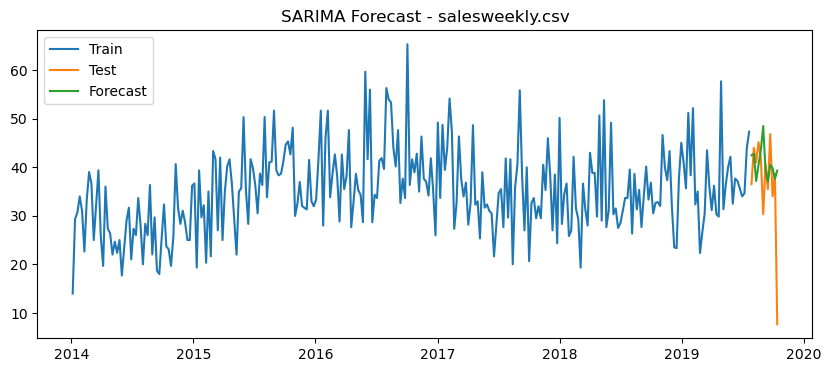

Next period forecast:
 2019-10-20    35.940886
2019-10-27    33.109576
2019-11-03    35.643987
2019-11-10    40.628686
2019-11-17    35.597614
Freq: W-SUN, Name: predicted_mean, dtype: float64

=== Running SARIMA for salesdaily.csv ===
AIC: 10014.943927206306 | Test RMSE: 2.897243303163187


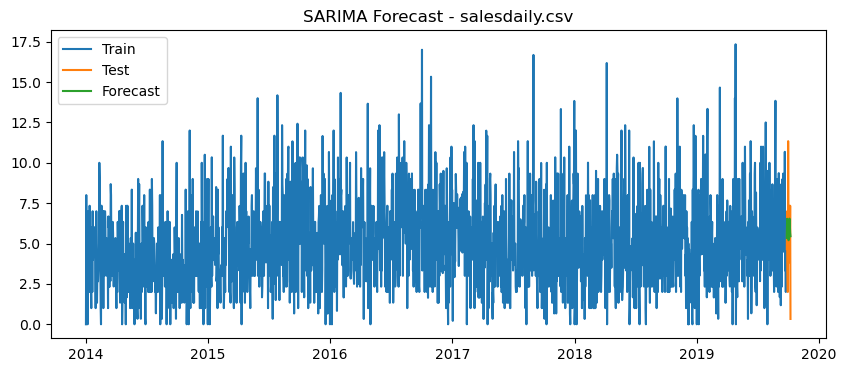

Next period forecast:
 2019-10-09    5.121507
2019-10-10    5.136630
2019-10-11    5.274626
2019-10-12    6.408297
2019-10-13    5.990404
Freq: D, Name: predicted_mean, dtype: float64

=== Running SARIMA for saleshourly.csv ===


In [ ]:
# Monthly (seasonal period = 12)
sarima_monthly, forecast_monthly = run_sarima("salesmonthly.csv", freq="M", seasonal_period=12)

# Weekly (seasonal period = 52)
sarima_weekly, forecast_weekly = run_sarima("salesweekly.csv", freq="W", seasonal_period=52)

# Daily (seasonal period = 7)
sarima_daily, forecast_daily = run_sarima("salesdaily.csv", freq="D", seasonal_period=7)

# Hourly (seasonal period = 24)
sarima_hourly, forecast_hourly = run_sarima("saleshourly.csv", freq="H", seasonal_period=24)
